### Evaluate Models

- Joel Stremmel
- 04-17-23

##### About

Loads the true labels and predicted probabilities of each label for each fold for each model and computes performance metrics.

##### Imports

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

##### Evaluation Parameters

In [2]:
threshold = 0.5
num_std = 1.96
line_width = 2
alpha = 0.2
font_size = 16
legend_size = 10
x_size = 10
y_size = 10

##### Load Labels and Predictions for each Model

In [3]:
all_y_trues, all_y_probs = [], []
all_model_names = {
    'lr': 'L2 Regularized Logistic Regression',
    'nb': 'Naive Bayes Classifier',
    'knn': 'K-Nearest Neighbors Classifier',
    'lfm': 'Longformer Mini',}
#     'lfb': 'Longformer Base',
#     'bbl': 'Big Bird Large',
#     'gpt_neo_1_3b': 'GPT-Neo 1.3B',
# }

# https://gist.github.com/thriveth/8560036
color_map = {
    'blue':    '#377eb8', 
    'red':     '#e41a1c',
    'brown':   '#a65628',
    'orange':  '#ff7f00',}
#     'green':   '#4daf4a',
#     'purple':  '#984ea3',
# }
colors = list(color_map.values())

for key in all_model_names.keys():

    with open(f'results/{key}_y_trues.pkl', 'rb') as f:
        y_trues = pickle.load(f)

    with open(f'results/{key}_y_probs.pkl', 'rb') as f:
        y_probs = pickle.load(f)
        
    all_y_trues.append(y_trues)
    all_y_probs.append(y_probs)

##### Define a Function to Print the Mean and Confidence Interval for a Given Metric

In [4]:
def print_mean_ci_of_metric_list(metric_list, metric_name, num_std):
    
    mean_metric = np.mean(metric_list)
    std_metric = np.std(metric_list)
    metric_low = np.maximum(mean_metric - std_metric * num_std, 0)
    metric_high = np.minimum(mean_metric + std_metric * num_std, 1)
    
    print(f"{metric_name}: {round(mean_metric, 3)} [{round(metric_low, 3)} - {round(metric_high, 3)}]")

##### Print Performance for all Metrics for all Models

In [5]:
for y_trues, y_probs, name, color in zip(all_y_trues, all_y_probs, all_model_names.values(), colors):
    
    accuracies, aps, precisions, recalls = [], [], [], []
    for y_true, y_prob in zip(y_trues, y_probs):
        
        y_pred = [1 if x >= threshold else 0 for x in y_prob]
        
        accuracy = metrics.accuracy_score(y_true=y_true, y_pred=y_pred)
        accuracies.append(accuracy)
        
        ap = metrics.average_precision_score(y_true=y_true, y_score=y_prob)
        aps.append(ap)
        
        precision = metrics.precision_score(y_true=y_true, y_pred=y_pred)
        precisions.append(precision)
        
        recall = metrics.recall_score(y_true=y_true, y_pred=y_pred)
        recalls.append(recall)
    
    print(f"\nResults for model: {name}\n")
    print_mean_ci_of_metric_list(accuracies, metric_name='Accuracy', num_std=num_std)
    print_mean_ci_of_metric_list(aps, metric_name='Average Precision', num_std=num_std)
    print_mean_ci_of_metric_list(precision, metric_name='Precision', num_std=num_std)
    print_mean_ci_of_metric_list(recall, metric_name='Recall', num_std=num_std)


Results for model: L2 Regularized Logistic Regression

Accuracy: 0.548 [0.423 - 0.674]
Average Precision: 0.809 [0.685 - 0.934]
Precision: 0.538 [0.538 - 0.538]
Recall: 1.0 [1.0 - 1.0]

Results for model: Naive Bayes Classifier

Accuracy: 0.551 [0.292 - 0.811]
Average Precision: 0.659 [0.3 - 1.0]
Precision: 0.5 [0.5 - 0.5]
Recall: 0.429 [0.429 - 0.429]

Results for model: K-Nearest Neighbors Classifier

Accuracy: 0.564 [0.46 - 0.667]
Average Precision: 0.601 [0.505 - 0.698]
Precision: 0.538 [0.538 - 0.538]
Recall: 1.0 [1.0 - 1.0]

Results for model: Longformer Mini

Accuracy: 0.63 [0.445 - 0.815]
Average Precision: 0.685 [0.428 - 0.942]
Precision: 0.556 [0.556 - 0.556]
Recall: 0.714 [0.714 - 0.714]


##### Plot Model ROC AUCs on the Same Graph with Confidence Intervals

<Figure size 640x480 with 0 Axes>

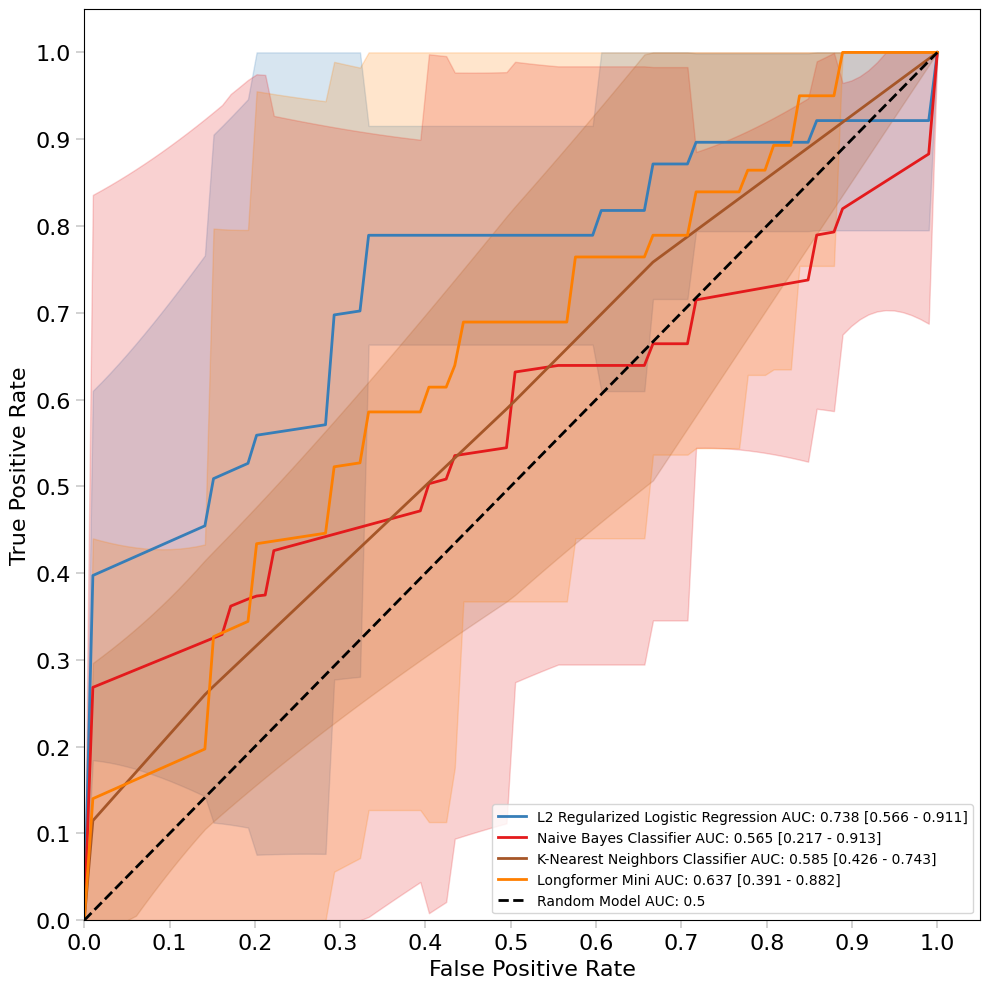

In [6]:
plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(x_size, y_size))

for y_trues, y_probs, name, color in zip(all_y_trues, all_y_probs, all_model_names.values(), colors):

    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    
    for y_true, y_prob in zip(y_trues, y_probs):
        
        fpr, tpr, _ = metrics.roc_curve(y_true, y_prob)
        
        auc = metrics.roc_auc_score(y_true, y_prob)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc)
        
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)
    
    tprs_high = np.minimum(mean_tpr + num_std * std_tpr, 1)
    tprs_low = np.maximum(mean_tpr - num_std * std_tpr, 0)
    
    mean_auc = np.mean(aucs, axis=0)
    std_auc = np.std(aucs, axis=0)
    auc_high = np.minimum(mean_auc + num_std * std_auc, 1)
    auc_low = np.maximum(mean_auc - num_std * std_auc, 0)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        color=color,
        lw=line_width,
        label=f"{name} AUC: {round(mean_auc, 3)} [{round(auc_low, 3)} - {round(auc_high, 3)}]"
    )
    
    ax.fill_between(
        mean_fpr,
        tprs_low,
        tprs_high,
        color=color,
        alpha=alpha
    )
    
plt.plot([0, 1], [0, 1], color='black', lw=line_width, linestyle='--', label="Random Model AUC: 0.5")
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xticks(np.arange(0, 1.1, 0.1))
ax.set_yticks(np.arange(0, 1.1, 0.1), minor=True)
ax.set_xticks(np.arange(0, 1.1, 0.1), minor=True)
ax.tick_params(direction='out', length=6, width=0.25, colors='black', labelsize=font_size)
ax.tick_params(axis='both', which='minor', width=0.25)
plt.xlabel('False Positive Rate', fontsize=font_size)
plt.ylabel('True Positive Rate', fontsize=font_size)
plt.legend(loc='lower right', fontsize=legend_size)
plt.tight_layout()
plt.savefig('results/roc.png')
plt.show()
plt.close()